In [1]:
%pip install entsoe-py -q

Note: you may need to restart the kernel to use updated packages.


2021-07-23

**Info:**

Use case 1: Risk managment department performing MC simulations model on MS Excel which is severly restricted in terms of column count/simulations (max. 15000).

Solution was proposed in order to keep the MS Excel environment and not compromise on the low count of simulations (risk managment recommendation is 250000 but 15000 were used).

Use case 2: Help business strategic investments based on lower amount of historical yearly data for solar production in Europe.

Solution was proposed in order to gain some confidence in investing in renewable power plants but the model outcome provided lower confidence in long term forecasted results.

**Introduction:**

Monte-carlo simulations are made based on stochastic formula which cumulatively project probabilistic future moves usually of time-series data type. The proposed method uses "volatility based probability projections" which are later proven to predict +inf MC simulation projections with very good accuracy and just a few computations rather than 250000 simulations. The proposed method will improve the accuracy and lower the complexity using mathematics rather than exhaustively computing simulations restricted by the used software.

**Notes:**

The plots are going to be unscaled but the calculations are going ot be performed under natural logarithmic scale explained in the last cell of the presentation.

In [2]:
import pandas as pd
import numpy as np
import torch
import math
from statistics import *
import matplotlib.pyplot as plt
%precision 4

'%.4f'

In [3]:
# Query data
from entsoe import EntsoePandasClient
client = EntsoePandasClient(api_key="7f8b171a-bcbb-4074-aba0-da5c8f68c7d8")
start = pd.Timestamp('20170101', tz='Europe/Sofia')
end = pd.Timestamp('20210723', tz='Europe/Sofia')

day_ahead_bg = client.query_day_ahead_prices('BG', start=start,end=end)

In [4]:
def hist_plot(x, n):
  '''
  Visualization function
  x = hist ready array, n = # of stdev (sigma)
  '''
  # Log transform
  end_normal = np.log(x[:,-1])
  stdev_x = stdev(end_normal)
  up_band_log = end_normal.mean() + n*stdev_x
  low_band_log = end_normal.mean() - n*stdev_x
  up_band = np.exp(up_band_log)
  low_band = np.exp(low_band_log)

  plt.figure(figsize=(14,8))
  plt.hist(x[:,-1], bins='fd')
  plt.axvline(x[:,-1].mean(), color='r', label='Mean')
  plt.axvline(up_band, c='orange', label='Basic +{} sigma'.format(n))
  plt.axvline(low_band, c='orange',label='Basic -{} sigma'.format(n))
  plt.axvline(bands.band_low[-1:].tolist(), c='black',label='theo_low')  # this will be computed in the beginning
  plt.axvline(bands.band_up[-1:].tolist(), c='black',label='theo_up')

  print('Expect return/drift for MC: ', x[:,-1].mean())
  print('Expect return/drift theoretical: ', bands['mean'][-1:].tolist())  # this will be computed in the beginning
  print('Basic -{} sigma: '.format(n), low_band)
  print('Basic +{} sigma: '.format(n), up_band)
  print('Theo -{} sigma: '.format(n), bands.band_low[-1:].tolist())
  print('Theo +{} sigma: '.format(n), bands.band_up[-1:].tolist())

  plt.title('MC histogram of end values')
  plt.xlabel('Price')
  plt.ylabel('Counts')
  plt.legend()
  plt.grid()
  plt.show()

,Close
2017-01-01 01:00:00+02:00,44.01
2017-01-01 02:00:00+02:00,38.08
2017-01-01 03:00:00+02:00,36.75
2017-01-01 04:00:00+02:00,36.91
2017-01-01 05:00:00+02:00,39.08
...,...
2021-07-22 20:00:00+03:00,204.31
2021-07-22 21:00:00+03:00,204.31
2021-07-22 22:00:00+03:00,209.76
2021-07-22 23:00:00+03:00,204.63


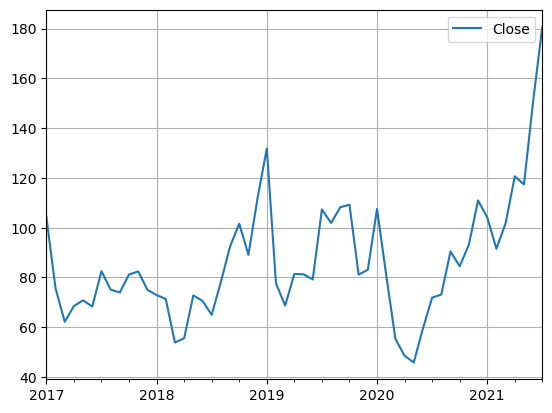

In [5]:
data = pd.DataFrame(day_ahead_bg)
data.columns = ['Close']
display(data)
# Filter outliers
data = data[(data['Close'] <= 300)]
data = data.resample('M').mean()
data.plot()
plt.grid()

In [6]:
## Set default parameters for the expirement
geo_ret = (data.Close[-1] / data.Close[0])**(1/len(data.Close)) -1
stdev_norm = stdev(data.Close.pct_change()[1:])
stdev_log = stdev((np.log(data.Close) - np.log(data.Close.shift(1)))[1:])
sigma = 2.576  # 99% confidence interval (client requirement)
n = 12

**Formulas:**

At the mean statistically 50% of the time the actual closing price will be higher than the forecasted median price and 50% of the time the actual price will be lower.\
Mean:
$P_m = P_c * e^{(GR*t)}$\
Upper band:
$P_u = P_c * e^{(GR*t + \sigma*StDev*\sqrt t)}$\
Lower band:
$P_l = P_c * e^{(GR*t - \sigma*StDev*\sqrt t)}$

Where:\
**$P_m$** - Mean price \
**$P_u$** - Upper limit price \
**$P_l$** - Lower limit price \
**GR** - geometric return = $(P_{end}/P_{start})^{(1/N)} -1$\
**t** - # of periods (months)\
**$\sigma$** - confidence interval multiplier (1=68.3%, 2=95%, 3=99.7%)\
**StDev** - historical standard deviation (HV) of log returns, can be used with (IV in exchange stock/index options contracts)\
$\sqrt t$ - sqrt of time


Example:\
-If we want to want to compute a mean/upper/lower limit value that should statistically only be exceeded 2.1% of the time, (+2 standard deviation or two sigma) 12 months from now, we can compute:

$100 * e^{(0.000433*12)} = 100.52$ or 0.5210% expected mean (drift) based on GR after 12 periods(months)\
$100 * e^{(0.000433*12 + 2*0.01*\sqrt 12)} = 107.73$ or +7.73%\
$100 * e^{(0.000433*12 - 2*0.01*\sqrt 12)} = 93.79$ or -6.21%



In [7]:
## Calculate theoretical limits
# performing 12 computations only

list_up = [data.Close[-1], ]
list_low = [data.Close[-1], ]
list_mean = [data.Close[-1], ]

for i in range(1, n+1):
  upper = data.Close[-1] * math.exp(geo_ret*i + (sigma*stdev_log*np.sqrt(i)))
  lower = data.Close[-1] * math.exp(geo_ret*i - (sigma*stdev_log*np.sqrt(i)))
  mean = data.Close[-1] * math.exp(geo_ret*i)
  list_up.append(upper)
  list_low.append(lower)
  list_mean.append(mean)
list_up = pd.Series(list_up)
list_low = pd.Series(list_low)
list_mean = pd.Series(list_mean)

In [8]:
## Concat results
bands = pd.concat([list_up, list_mean, list_low], axis=1, keys=['band_up', 'mean','band_low'])
bands

,band_up,mean,band_low
0,180.873327,180.873327,180.873327
1,290.494200,182.701728,114.907359
2,355.570773,184.548612,95.784560
3,416.202761,186.414166,83.493538
4,476.032563,188.298578,74.483044
5,536.472736,190.202039,67.434584
6,598.270818,192.124741,61.697671
7,661.899433,194.066880,56.899813
8,727.696185,196.028651,52.806697
9,795.924939,198.010254,49.261003


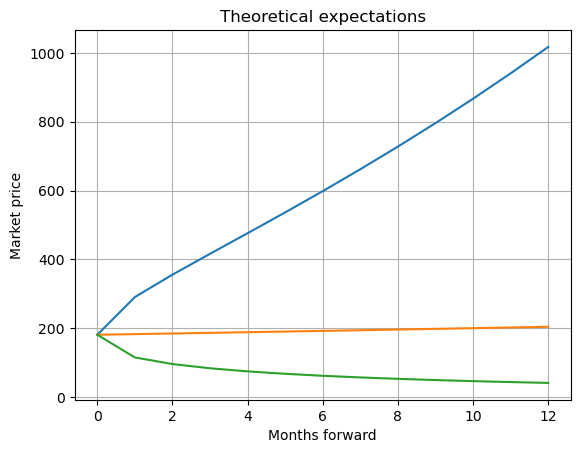

In [9]:
## Bands result (static)
plt.plot(bands)
plt.title('Theoretical expectations')
plt.xlabel('Months forward')
plt.ylabel('Market price')
plt.grid()

Monte Carlo assumption:

$\Delta S = S_{t-1}(\mu\Delta t + \sigma\epsilon\sqrt\Delta t)$ \
Where:\
$\mu$ = Geometric Return (GR) \
$\Delta t$ =  # of periods forward\
$\sigma$ = historical volatility (stdev) \
$\epsilon$ = normally distributed random variable {0,1} \
$\sqrt\Delta t$ = down scaler (if we use annual vol)

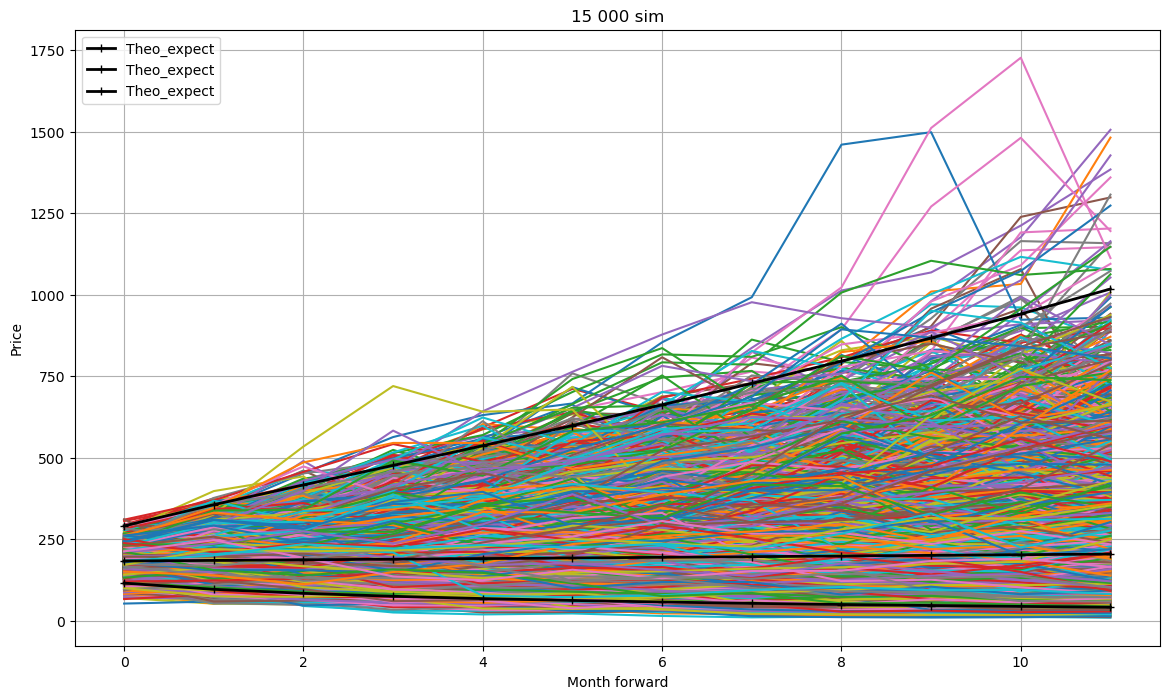

In [10]:
## 15 000 simulations (draft)
plt.figure(figsize=(14,8))
x = np.cumprod(geo_ret + (1+np.random.randn(15000,12)*stdev_log),1) * data.Close[-1]
for i in x:
  plt.plot(i)
plt.plot(bands.shift(-1), c='black', label='Theo_expect',
                     linewidth=2.0, marker='+')
plt.title('15 000 sim')
plt.xlabel('Month forward')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Expect return/drift for MC:  205.01053438587076
Expect return/drift theoretical:  [204.0760615298727]
Basic -2.576 sigma:  31.3707868126473
Basic +2.576 sigma:  892.0779599842111
Theo -2.576 sigma:  [40.93925867821078]
Theo +2.576 sigma:  [1017.2885448878515]


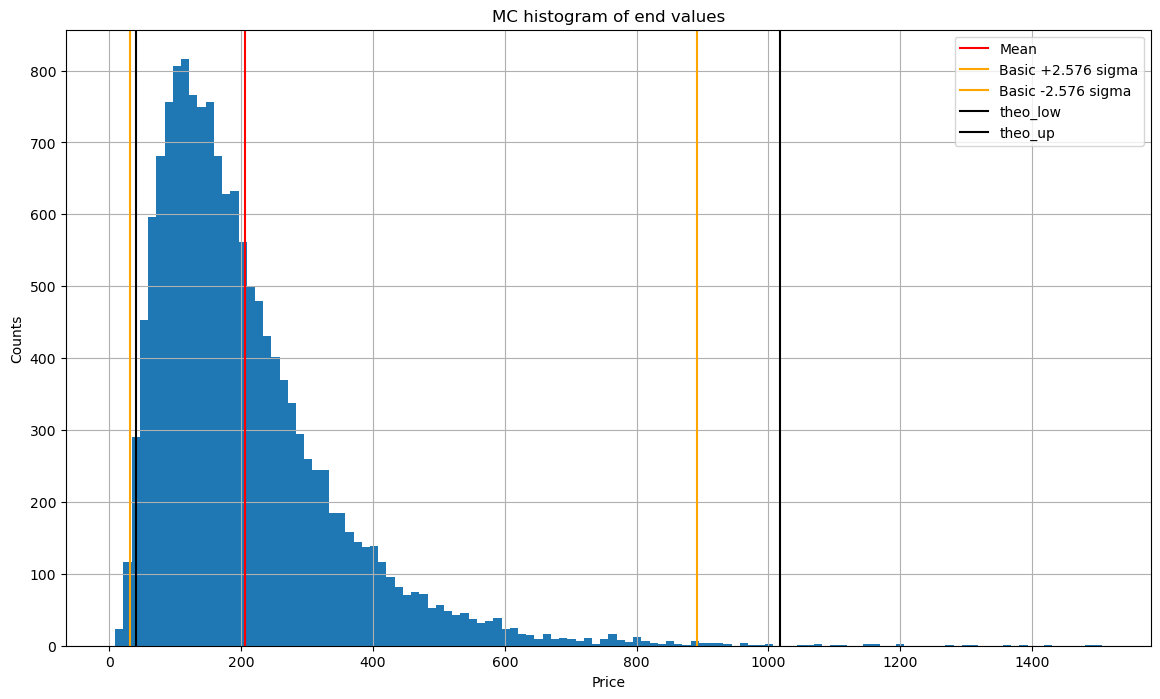

In [11]:
## Histogram of 15 000 ending simulation values (draft)
hist_plot(x, sigma)

____________________________
100 Simulations: 
Theoretical method:  3.0 %
Basic method:  1.0 %

Expect return/drift for MC:  226.74708761240782
Expect return/drift theoretical:  [204.0760615298727]
Basic -2.576 sigma:  24.858461002759817
Basic +2.576 sigma:  1236.8734224584316
Theo -2.576 sigma:  [40.93925867821078]
Theo +2.576 sigma:  [1017.2885448878515]


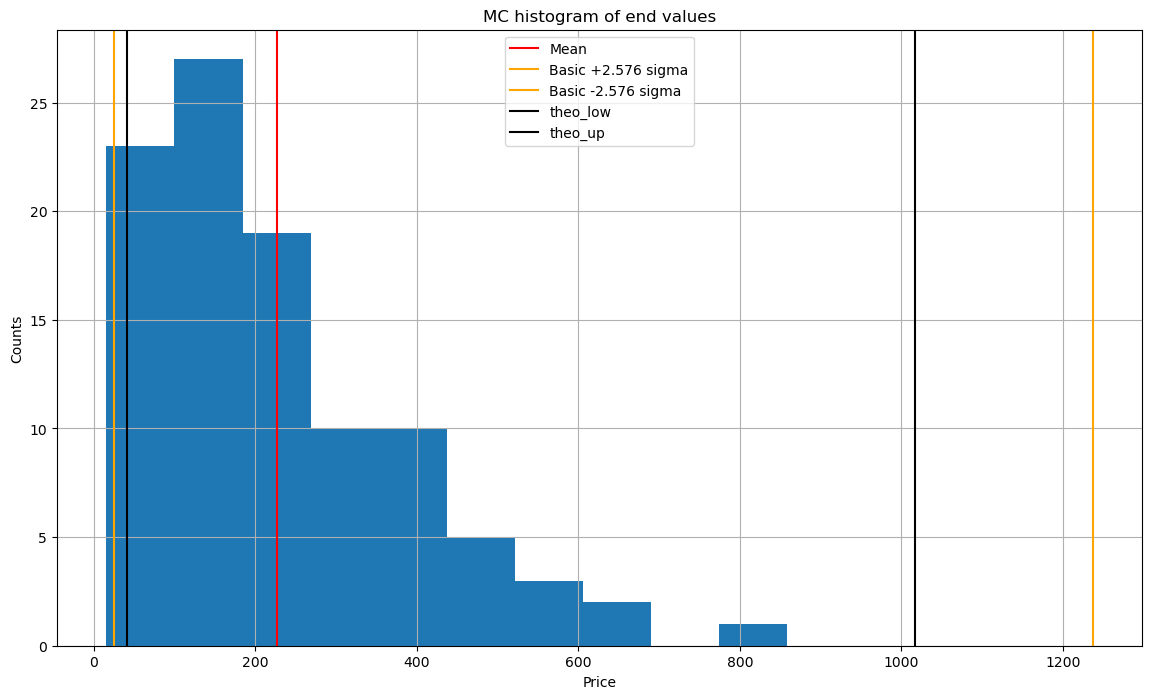


____________________________
1000 Simulations: 
Theoretical method:  2.3 %
Basic method:  1.1 %

Expect return/drift for MC:  207.83794113233833
Expect return/drift theoretical:  [204.0760615298727]
Basic -2.576 sigma:  31.882050851608575
Basic +2.576 sigma:  905.3977469156487
Theo -2.576 sigma:  [40.93925867821078]
Theo +2.576 sigma:  [1017.2885448878515]


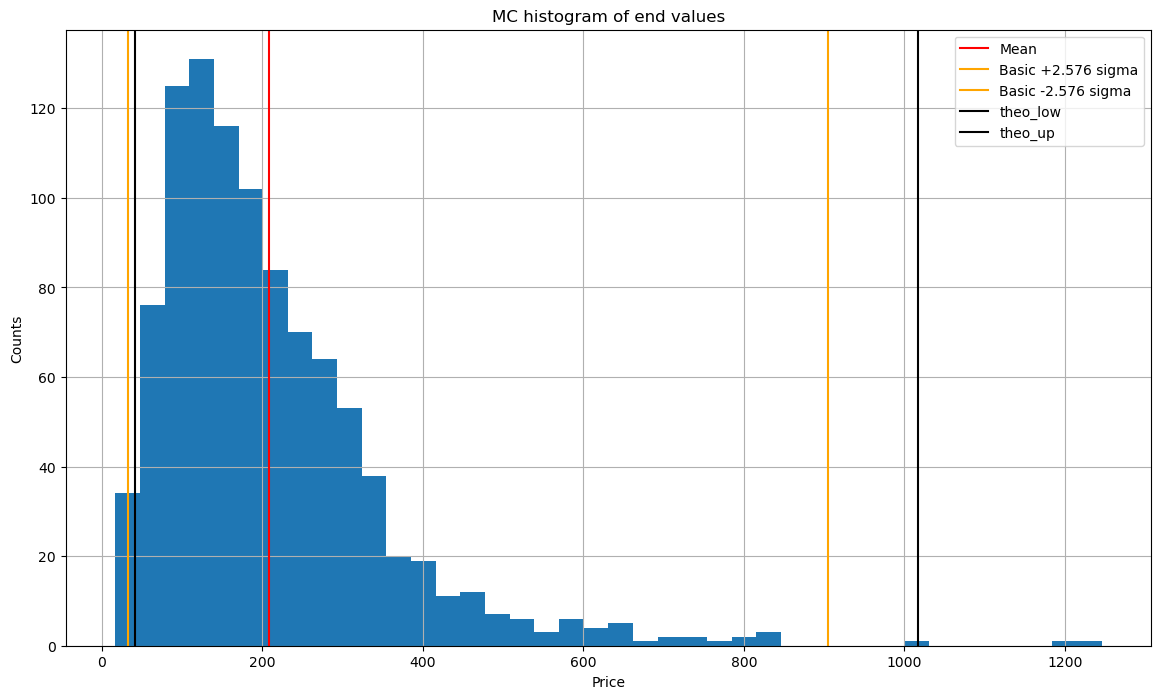


____________________________
15000 Simulations: 
Theoretical method:  2.17 %
Basic method:  1.1 %

Expect return/drift for MC:  203.91343727738803
Expect return/drift theoretical:  [204.0760615298727]
Basic -2.576 sigma:  31.177160674787906
Basic +2.576 sigma:  888.423961069384
Theo -2.576 sigma:  [40.93925867821078]
Theo +2.576 sigma:  [1017.2885448878515]


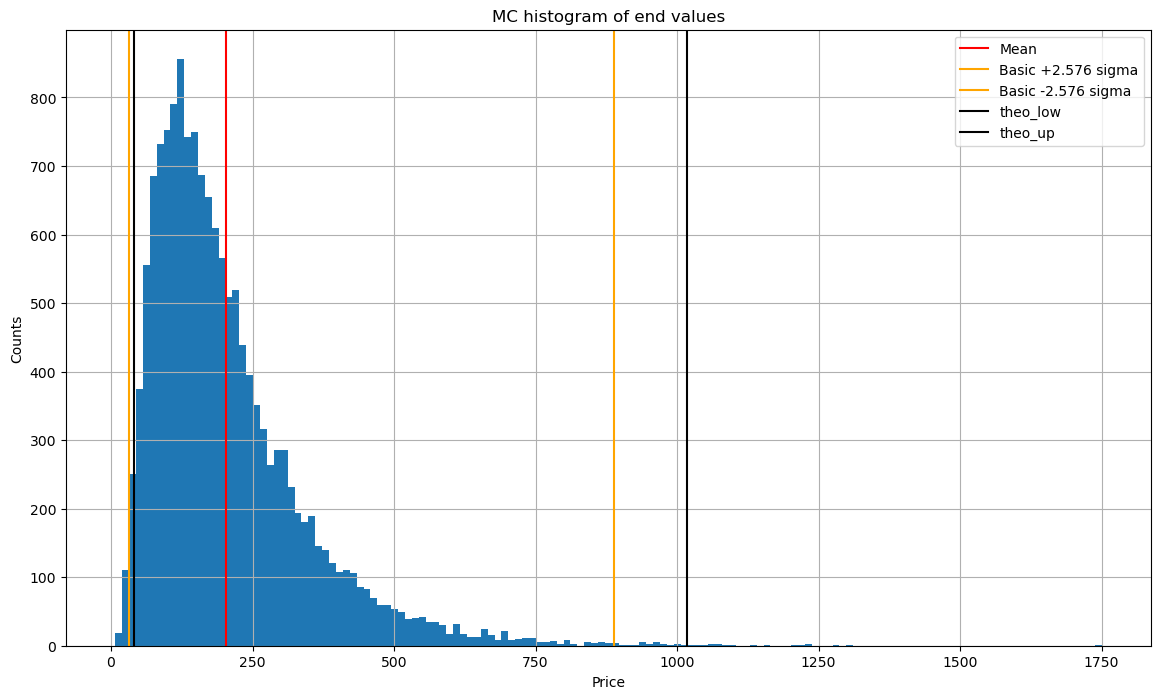


____________________________
100000 Simulations: 
Theoretical method:  2.04 %
Basic method:  1.09 %

Expect return/drift for MC:  204.21392357188714
Expect return/drift theoretical:  [204.0760615298727]
Basic -2.576 sigma:  31.651684385725563
Basic +2.576 sigma:  881.711044246284
Theo -2.576 sigma:  [40.93925867821078]
Theo +2.576 sigma:  [1017.2885448878515]


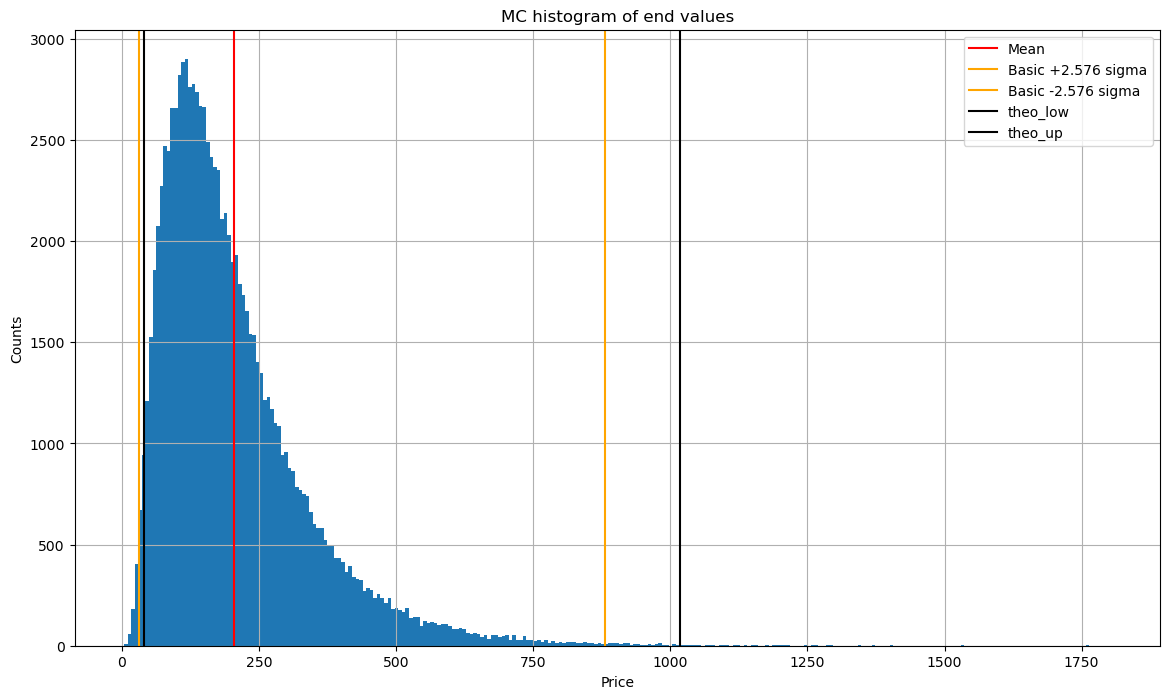


____________________________
250000 Simulations: 
Theoretical method:  2.03 %
Basic method:  1.05 %

Expect return/drift for MC:  204.06492079793614
Expect return/drift theoretical:  [204.0760615298727]
Basic -2.576 sigma:  31.68347490842862
Basic +2.576 sigma:  879.953622647393
Theo -2.576 sigma:  [40.93925867821078]
Theo +2.576 sigma:  [1017.2885448878515]


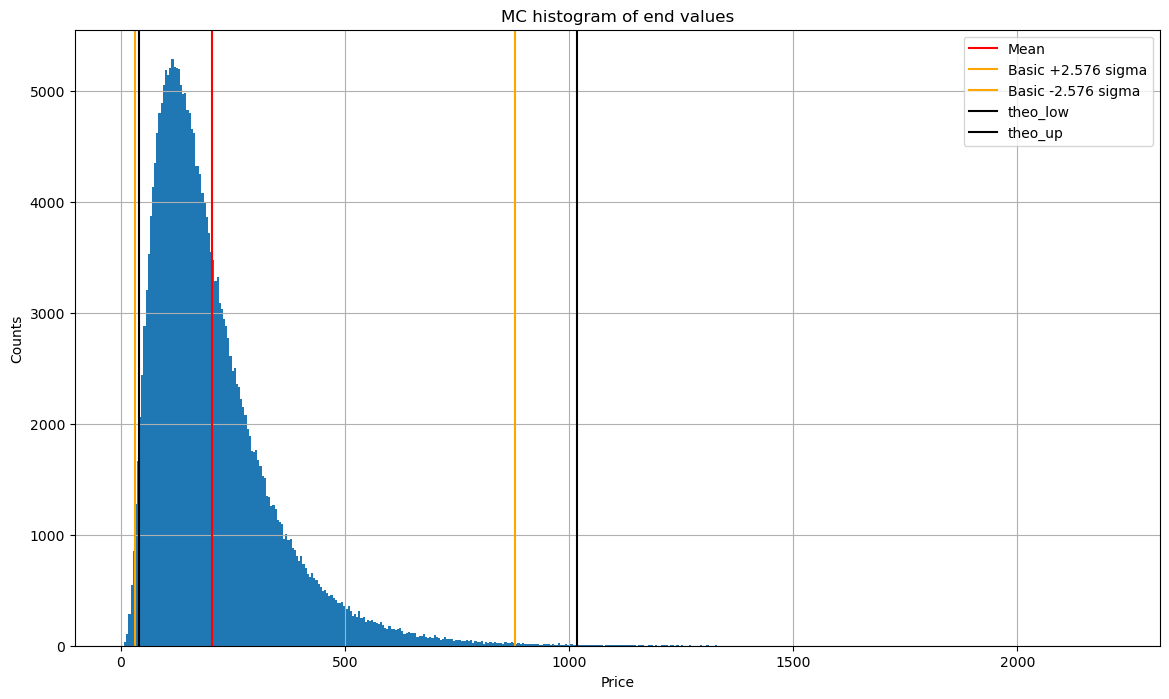


____________________________
1000000 Simulations: 
Theoretical method:  2.04 %
Basic method:  1.06 %

Expect return/drift for MC:  204.03722475551282
Expect return/drift theoretical:  [204.0760615298727]
Basic -2.576 sigma:  31.584661610491782
Basic +2.576 sigma:  881.3848571651642
Theo -2.576 sigma:  [40.93925867821078]
Theo +2.576 sigma:  [1017.2885448878515]


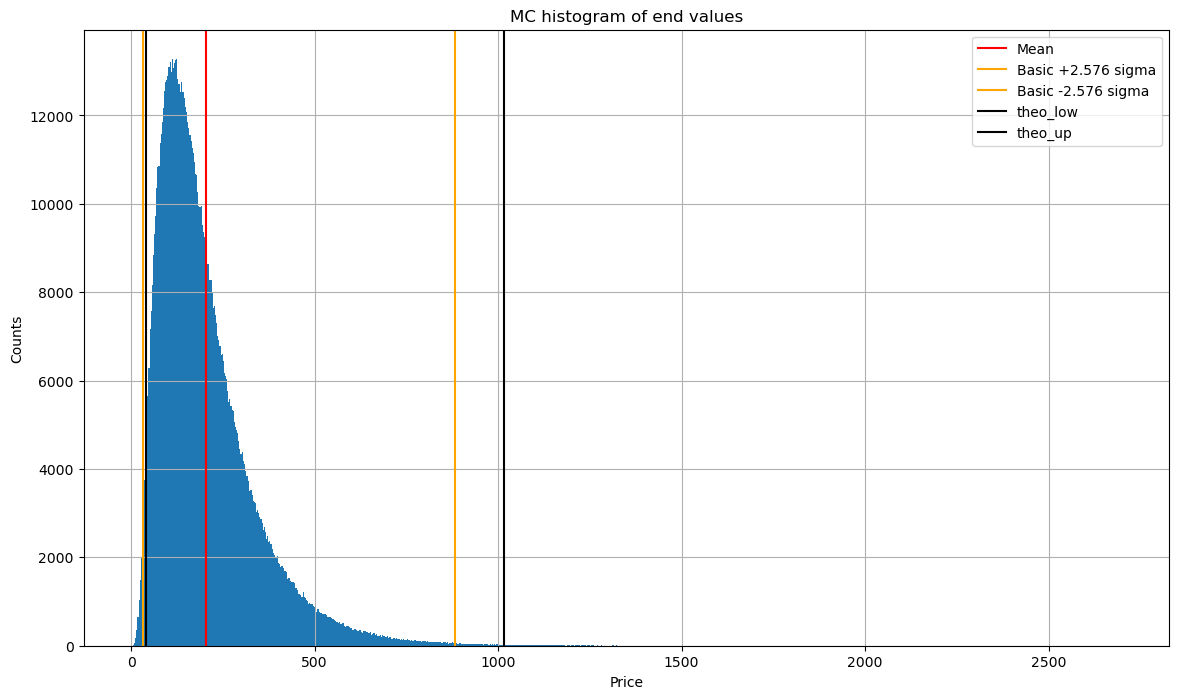

In [12]:
## Proof of concept

for i in [100, 1000, 15000, 100000, 250000, 1000000]:
  '''
  The idea is to compare initially computed "bands" that are based on proposed method
  and are static for the experiment
  with multiple MC simulations with increasing count of simulated lines
  after each the n-stdev are calculated and compared with the "bands".
  '''
  # Variables
  x = np.cumprod(geo_ret + (1+np.random.randn(i,12)*stdev_log),1) * data.Close[-1]  # monte-carlo
  x_df = pd.DataFrame(x)
  end_val = x_df[11]
  stdev_x = stdev(end_val)
  n = sigma
  # Log transform
  end_normal = np.log(end_val)
  stdev_x = stdev(end_normal)
  up_band_log = end_normal.mean() + n*stdev_x
  low_band_log = end_normal.mean() - n*stdev_x
  # Inverse transform
  up_band = np.exp(up_band_log)
  low_band = np.exp(low_band_log)

  basic_overshoot = end_val[end_val > up_band].count()
  basic_undershoot = end_val[end_val < low_band].count()
  basic_proof = (basic_overshoot + basic_undershoot) / end_val.count()

  theo_overshoot = end_val[end_val > bands.band_up[12]].count()
  theo_undershoot = end_val[end_val < bands.band_low[12]].count()
  theo_proof = (theo_overshoot + theo_undershoot) / end_val.count()

  print('____________________________')
  print(i, 'Simulations: ')
  print('Theoretical method: ', round(theo_proof *100, 2),'%')
  print('Basic method: ', round(basic_proof *100, 2),'%')
  print('')
  hist_plot(x, sigma)
  print('')
  ## 100 Simulations have visual problem only 1/100 is out and Theoretical method:  2.0 % ?!?!

**Notes:**\
Based on the results we see that theoretical limits are much more representable of two standard deviations or 2.1% of the simulated projections overshooted beyond them. When we see the 2 stdev. of the Monte carlo average we see that the model usually tend to overfit and expand more than needed. Thus we can conclude that the volatility based limits are better predictor and will do more accurate forecasts with significantly less computing.

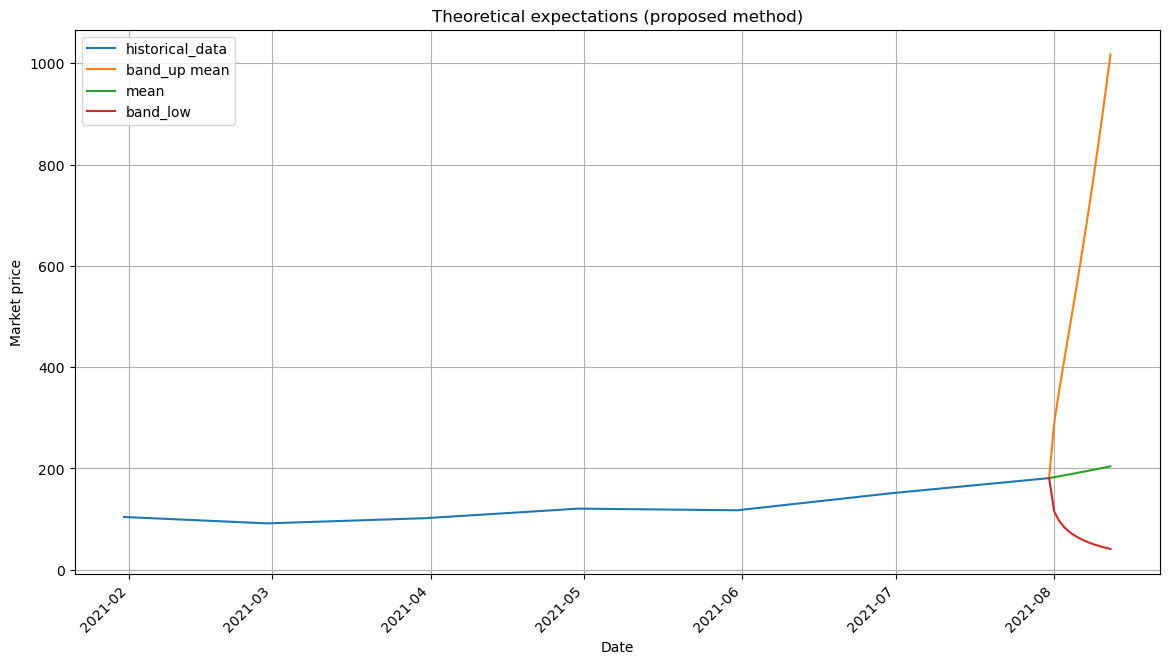

In [13]:
from datetime import timedelta
## Visualize projection on time-series structure

hist_price = pd.Series(data.Close[1:])
bands.index = pd.date_range(hist_price.index[-1], hist_price.index[-1] + timedelta(days=len(bands)-1))
x = pd.concat([hist_price,bands])
x.columns = ['historical_data', 'band_up mean', 'mean', 'band_low']

x[-20:].plot(figsize=(14,8))
plt.title('Theoretical expectations (proposed method)')
plt.xlabel('Date')
plt.ylabel('Market price')
plt.xticks(rotation=45)
plt.grid()

**Result notes:**\
Current reading of the plot is that 99% of the time for the next 12 periods in the future we expect to fall between the upper and lower projection bands based on historical volatility of the time-series.

In [14]:
# Log transform the distribution (example)
end_normal = np.log(x[:,-1])
stdev_x = stdev(end_normal)
up_band_log = end_normal.mean() + 3*stdev_x
low_band_log = end_normal.mean() - 3*stdev_x
up_band = np.exp(up_band_log)
low_band = np.exp(low_band_log)

plt.figure()
plt.title('Log scale')
plt.axvline(end_normal.mean(), color='r', label='Mean')
plt.axvline(up_band_log, color='r', label='up_band_log')
plt.axvline(low_band_log, color='r', label='low_band_log')
plt.hist(end_normal, bins=100)
plt.legend()

plt.figure()
plt.title('Original scale')
plt.axvline(up_band, color='orange', label='up_band')
plt.axvline(low_band, color='orange', label='low_band')
plt.hist(x[:,-1], bins=100)
plt.legend()
plt.show()

InvalidIndexError: (slice(None, None, None), -1)